# COMMOT

https://github.com/zcang/COMMOT

Tutorial Visium Data: https://commot.readthedocs.io/en/latest/notebooks/visium-mouse_brain.html

In [118]:
import commot as ct
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import squidpy as sq
import decoupler as dc
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
input_path = "/lustre/groups/ml01/datasets/2024_spatial_ccc_experiments_francesca.drummer/dataset.h5ad"
output_path = "/lustre/groups/ml01/datasets/2024_spatial_ccc_experiments_francesca.drummer/experiments/prediction_commot.h5ad"

# Communication inference 

In [32]:
adata = ad.read_h5ad(input_path)
adata

AnnData object with n_obs × n_vars = 37068 × 1122
    obs: 'brain_section_label', 'brain_section_label_right', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'dataset_id', 'sample_id', 'donor_id', 'condition_id', 'tissue', 'organism', 'assay_ontology', 'assay', 'celltype', 'fov'
    var: 'gene_symbol', 'name', 'mapped_ncbi_identifier'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'counts', 'normalized'

In [ ]:
sq.pl.spatial_scatter(
    adata,
    spatial_key = 'spatial',
    shape=None,
    library_key='fov', 
    color="celltype"
)

In [33]:
adata.X = adata.layers['counts']
adata.X

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 2., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [34]:
df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type='Secreted Signaling', database='CellChat')
print(df_cellchat.shape)

(1209, 4)


In [35]:
df_cellchat.head()

,0,1,2,3
0,Tgfb1,Tgfbr1_Tgfbr2,TGFb,Secreted Signaling
1,Tgfb2,Tgfbr1_Tgfbr2,TGFb,Secreted Signaling
2,Tgfb3,Tgfbr1_Tgfbr2,TGFb,Secreted Signaling
3,Tgfb1,Acvr1b_Tgfbr2,TGFb,Secreted Signaling
4,Tgfb1,Acvr1c_Tgfbr2,TGFb,Secreted Signaling


In [36]:
adata.var_names = adata.var["gene_symbol"]

filter LR pairs to keep only the pairs with both ligand and receptor expressed in at least 5%

In [37]:
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata, min_cell_pct=0.01)
print(df_cellchat_filtered.shape)

(23, 4)


Perform signal inference. The signaling results are stored as spot-by-spot matrices in the obsp slots. For example, the score for spot i signaling to spot j through the LR pair can be retrieved from `adata_dis500.obsp['commot-cellchat-Wnt4-Fzd4_Lrp6'][i,j]`.

In [ ]:
ct.tl.spatial_communication(adata,
    database_name='user_database', df_ligrec=df_cellchat_filtered, dis_thr=200, heteromeric=True, pathway_sum=True)

In [ ]:
adata.write(f"{output_path}/Zhuang23_commot.h5ad")

# Analyze

In [129]:
adata_out = ad.read_h5ad(output_path)
adata_out

AnnData object with n_obs × n_vars = 37068 × 1122
    obs: 'brain_section_label', 'brain_section_label_right', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'dataset_id', 'sample_id', 'donor_id', 'condition_id', 'tissue', 'organism', 'assay_ontology', 'assay', 'celltype', 'fov'
    var: 'gene_symbol', 'name', 'mapped_ncbi_identifier'
    uns: 'commot-user_database-info', 'log1p'
    obsm: 'commot-user_database-sum-receiver', 'commot-user_database-sum-sender', 'spatial'
    layers: 'counts', 'normalized'
    obsp: 'commot-user_database-AGT', 'commot-user_database-Agt-Agtr1a', 'commot-user_database-CRH', 'commot-user_database-Crh-Crhr1', 'commot-user_database-Crh-Crhr2', 'commot-user_database-GA

In [130]:
adata_out.obsp['commot-user_database-NTS'][0,:100]

<1x100 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [131]:
ct.tl.communication_direction(adata_out, database_name='user_database', pathway_name='AGT', k=5)

score for spot i signaling to spot j through the LR pair can be retrieved from `adata_dis500.obsp['commot-cellchat-Wnt4-Fzd4_Lrp6'][i,j]`

In [161]:
adata.obs['Nts-Ntsr2'] = adata_out.obsp['commot-user_database-Nts-Ntsr2'].sum(axis=1)

np.unique(adata.obs['Nts-Ntsr2']>0)

array([False,  True])

In [167]:
def min_max_normalization(data):
    min_val = min(data)
    max_val = max(data)
    normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
    return normalized_data

In [170]:
adata.obs['Nts-Ntsr2'] = min_max_normalization(adata.obs['Nts-Ntsr2'])

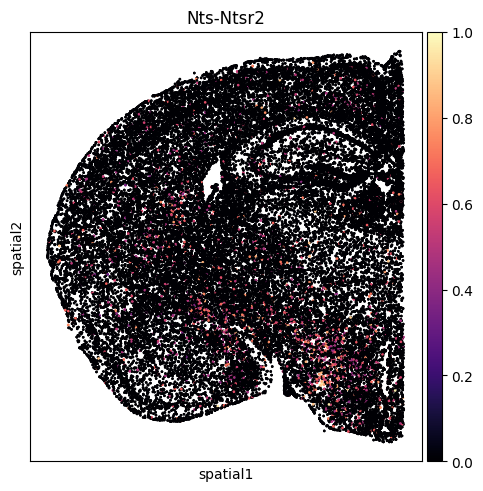

In [171]:
sq.pl.spatial_scatter(
    adata,
    spatial_key = 'spatial',
    shape=None,
    library_key='fov', 
    color="Nts-Ntsr2",
    cmap="magma"
)

In [20]:
ct.tl.communication_direction(adata_out, database_name='user_database', pathway_name='AGT', k=5)
array = adata_out.obsm['commot_sender_vf-user_database-AGT'] #signalling direction of cells/spots
non_zero_rows = array[np.any(array != 0, axis=1)]
print(len(non_zero_rows))

11421


In [155]:
# ct.pl.plot_cell_communication(adata_out, database_name='user_database', pathway_name='AGT', plot_method='grid', background_legend=True,
#     scale=0.00003, ndsize=8, grid_density=0.4, summary='sender', clustering='leiden', cmap='Alphabet',
#     normalize_v = True, normalize_v_quantile=0.995)

In [116]:
ct.tl.cluster_communication(adata_out, database_name='user_database', pathway_name='AGT', clustering='leiden',
    n_permutations=100)

In [172]:
# ct.pl.plot_cluster_communication_network(adata_out, uns_names=['commot_cluster-leiden-user_database-AGT'],
#     nx_node_pos=None, nx_bg_pos=False, p_value_cutoff = 5e-2, filename='AGT_cluster.pdf', nx_node_cmap='Light24')

In [173]:
# df_deg, df_yhat = ct.tl.communication_deg_detection(adata_out,
#     database_name = 'user_database', pathway_name='AGT', summary = 'receiver')

## Comparison LIANA+

In [49]:
Nts_Ntsr2 = adata_out.obsp['commot-user_database-Nts-Ntsr2']
Nts_Ntsr2

<37068x37068 sparse matrix of type '<class 'numpy.float64'>'
	with 31246264 stored elements in Compressed Sparse Row format>

In [90]:
cell_type_annotations = adata_out.obs['celltype']
unique_cell_types, cell_type_indices = np.unique(cell_type_annotations, return_inverse=True)
unique_cell_types

array(['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 OB-CR Glut',
       '04 DG-IMN Glut', '05 OB-IMN GABA', '06 CTX-CGE GABA',
       '07 CTX-MGE GABA', '08 CNU-MGE GABA', '09 CNU-LGE GABA',
       '10 LSX GABA', '11 CNU-HYa GABA', '12 HY GABA', '13 CNU-HYa Glut',
       '14 HY Glut', '16 HY MM Glut', '17 MH-LH Glut', '18 TH Glut',
       '19 MB Glut', '20 MB GABA', '25 Pineal Glut', '30 Astro-Epen',
       '31 OPC-Oligo', '33 Vascular', '34 Immune'], dtype=object)

In [86]:
adata_Nts_Ntsr2= ad.AnnData(X=Nts_Ntsr2, obs = {'celltype': adata_out.obs['celltype']}, var = {'celltype': adata_out.obs['celltype']})
adata_Nts_Ntsr2.var_names = adata_out.obs['celltype']
adata_Nts_Ntsr2.obs_names = adata_out.obs['celltype']
adata_Nts_Ntsr2

AnnData object with n_obs × n_vars = 37068 × 37068
    obs: 'celltype'
    var: 'celltype'

In [126]:
def merge_cell_type_scores(adata):
    """
    input: Adata with 
        .X: NxN matrix with N = cells 
        .obs_names and .var_names: Nx1 (cell types)
    output: scores (CxC)
    """

    sparse_matrix = adata.X

    cell_types = np.unique(adata.obs_names)

    scores = np.zeros((len(cell_types), len(cell_types)))

    for row, ct_row in enumerate(cell_types): 
        ct_scores = sparse_matrix[adata.obs_names == ct_row]
        print(ct_scores.shape)
        for col, ct_col in enumerate(cell_types):
            ct_scores = ct_scores[adata.var_names['celltype'] == ct]
            scores[row][col] = np.mean(ct_scores)
            print(np.mean(ct_scores))

In [127]:
merge_cell_type_scores(adata_Nts_Ntsr2)

(6069, 37068)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [101]:
# Example data
sparse_matrix = adata_out.obsp['commot-user_database-Nts-Ntsr2']
cell_type_annotations = adata_out.obs['celltype']

# Identify unique cell types and map them to indices
unique_cell_types, cell_type_indices = np.unique(cell_type_annotations, return_inverse=True)

# Convert the sparse matrix to COO format to extract rows, cols, and data
sparse_matrix = sp.coo_matrix(sparse_matrix)

# Create a DataFrame with cell type annotations for rows and columns
df = pd.DataFrame({
    'row': cell_type_indices[sparse_matrix.row],
    'col': cell_type_indices[sparse_matrix.col],
    'data': sparse_matrix.data
})

# Group by cell types and calculate the mean interaction scores
grouped = df.groupby(['row', 'col'])['data'].mean().unstack(fill_value=0)

# Convert the indices back to cell type labels
grouped.index = unique_cell_types[grouped.index]
grouped.columns = unique_cell_types[grouped.columns]

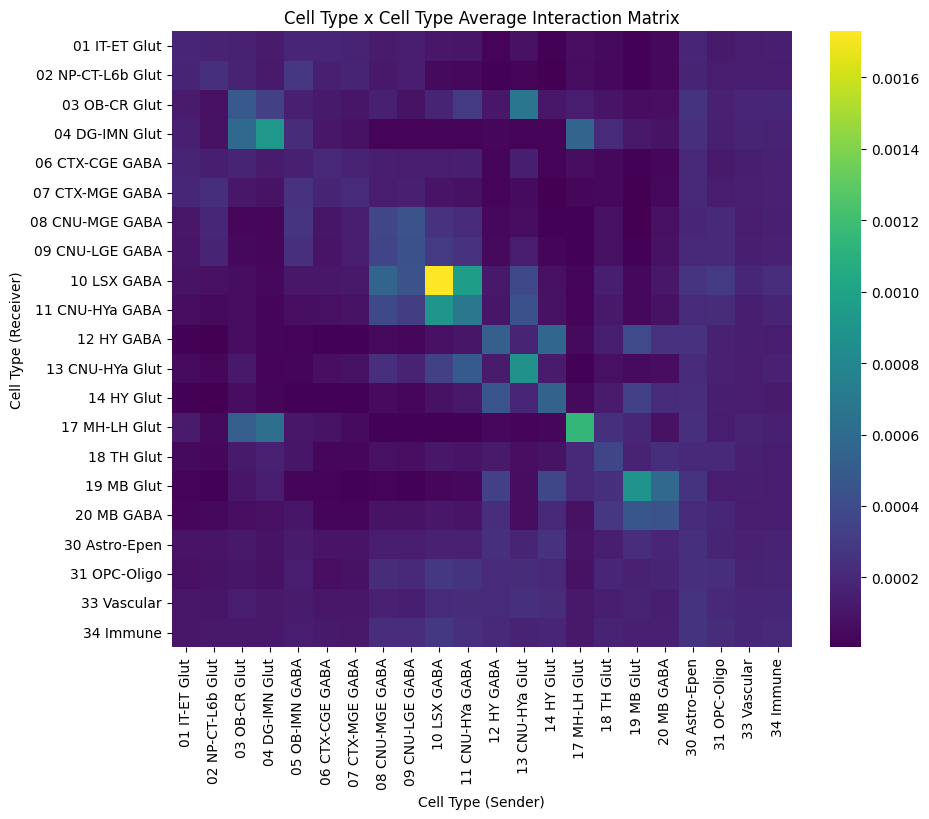

In [103]:
plt.figure(figsize=(10, 8))
sns.heatmap(grouped, xticklabels=grouped.columns, yticklabels=grouped.index, cmap='viridis')
plt.title('Cell Type x Cell Type Average Interaction Matrix')
plt.xlabel('Cell Type (Sender)')
plt.ylabel('Cell Type (Receiver)')
plt.show()

In [121]:
grouped.shape

(21, 22)